<a href="https://www.kaggle.com/code/klaydaahin/aygaz-bootcamp-goruntu-isleme?scriptVersionId=214212968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/README-images.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/trainclasses.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix-continuous.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix-binary.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/README-attributes.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix.png
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicates.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/testclasses.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/classes.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/licenses/fox/fox_10525.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/licenses/fox/fox_10049.txt
/kaggle/input/animals-with-attributes-2/Animals_wi

Başlangıçta, projenin tüm adımları için ihtiyaç duyulan kütüphaneleri içe aktaralım

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
# Veri seti klasörlerinin yolları
source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"  # Veri seti klasörünün yolu
target_dir = "FilteredImages"  # Filtrelenmiş verilerin kaydedileceği yol

In [4]:
# Kullanılacak sınıflar
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650


In [5]:
# Filtreleme ve resimleri kopyalama
os.makedirs(target_dir, exist_ok=True)
for class_name in selected_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(target_dir, class_name)
    os.makedirs(target_path, exist_ok=True)
    for i, file_name in enumerate(os.listdir(class_path)):
        if i >= images_per_class:  # Sınıf başına belirli sayıda görüntü al
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            img = cv2.imread(full_file_name)
            if img is not None:
                cv2.imwrite(os.path.join(target_path, file_name), img)
print("Veri seti hazırlandı ve dengelendi.")

Veri seti hazırlandı ve dengelendi.


#### Adımlar:
1. **Klasörlerdeki Görüntüler:**
   - `data_dir` içinde bulunan her bir alt klasör (sınıf adı) için, o klasördeki tüm görüntü dosyalarını okur.
   
2. **Resimlerin Okunması ve Boyutlandırılması:**
   - Her bir görüntü dosyası, OpenCV (`cv2.imread`) kullanılarak okunur.
   - Ardından, her bir görüntü belirtilen boyutlara (128x128) yeniden boyutlandırılır.

3. **Normalizasyon:**
   - Resim, `255.0`'a bölünerek 0 ile 1 arasında normalize edilir. Bu, görüntülerin daha iyi bir şekilde öğrenilmesini sağlar.

4. **Etiketlerin Alınması:**
   - Her resme ait sınıf etiketi (alt klasör adı) toplanır ve etiketler listesine eklenir.

In [6]:
# Görüntülerin işlenmesi (128x128 boyutlandırma ve normalizasyon)
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0  # Görüntüyü normalize et
                    images.append(img_normalized)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

data_dir = target_dir
X, y = load_and_process_images(data_dir)
print(f"Veri kümesi boyutu: {X.shape}")

Veri kümesi boyutu: (6500, 128, 128, 3)


In [7]:
# Etiketlerin dönüştürülmesi (sınıf etiketlerini sayılara dönüştürme)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


#### Adımlar:
1. **`train_test_split` Fonksiyonu:**
   - Bu fonksiyon, veriyi rastgele ikiye böler. Eğitim seti için %70, test seti için %30 kullanılmıştır.
   - `random_state=42` parametresi, aynı bölmeyi tekrarlamak için sabit bir rastgelelikin sağlanmasını sağlar, böylece her çalıştırmada aynı eğitim ve test verileri kullanılır.

2. **Eğitim ve Test Veri Setlerinin Boyutları:**
   - Eğitim veri kümesi (`X_train` ve `y_train`) modelin öğrenmesi için kullanılırken,
   - Test veri kümesi (`X_test` ve `y_test`), modelin eğitildikten sonra doğruluğunu değerlendirmek için kullanılır.

In [8]:
# Veriyi eğitim ve test olarak bölme (%70 eğitim, %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")

Eğitim veri boyutu: (4550, 128, 128, 3), Test veri boyutu: (1950, 128, 128, 3)


In [9]:
# Veri artırma (augmentation) işlemi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


### CNN Modeli Özeti

Bu model, 128x128 boyutlarında ve RGB renkli görüntüler üzerinde çalışan bir **Convolutional Neural Network (CNN)**'dir. Temel amacı, görüntüleri işleyerek 10 farklı sınıfa ait etiketleri tahmin etmektir.

#### Modelin Yapısı:
1. **Giriş Katmanı:** 128x128 boyutunda, 3 kanallı (RGB) görüntüler.
2. **Konvolüsyon Katmanları:** Görüntüdeki özellikleri öğrenmek için 3 konvolüsyon katmanı ve her biri sonrası max pooling (havuzlama) kullanılır.
3. **Düzleştirme (Flatten):** Konvolüsyon ve havuzlama katmanları sonunda veriler bir vektöre dönüştürülür.
4. **Tam Bağlantılı Katmanlar:** 128 nörondan oluşan bir katman ve aşırı uyumu engellemek için Dropout eklenir.
5. **Çıkış Katmanı:** 10 sınıfı tahmin etmek için **softmax** aktivasyon fonksiyonu kullanılır.

In [10]:
# CNN Modeli
model = Sequential([
    Input(shape=(128, 128, 3)),  # 128x128 RGB görüntüler
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Konvolüsyon katmanı
    MaxPooling2D(pool_size=(2, 2)),  # Havuzlama katmanı
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Diğer konvolüsyon katmanı
    MaxPooling2D(pool_size=(2, 2)),  # Havuzlama katmanı
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Daha derin konvolüsyon katmanı
    MaxPooling2D(pool_size=(2, 2)),  # Havuzlama katmanı
    Flatten(),  # Katmanları düzleştir
    Dense(128, activation='relu'),  # Tam bağlantılı katman
    Dropout(0.5),  # Aşırı uyumu önlemek için Dropout
    Dense(10, activation='softmax')  # 10 sınıf için çıkış katmanı (softmax ile)
])


In [11]:
# Modeli derleme
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Model kaydetme için callback
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)


In [13]:
# Erken durdurma (early stopping) için callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

### Modeli Eğitme

Modelin eğitimi için `fit` fonksiyonu kullanılır. Bu fonksiyon, eğitim verisini (X_train, y_train) kullanarak modelin ağırlıklarını günceller ve validation verisi (X_test, y_test) ile doğrulama işlemi yapar.

- **Datagen**: Veri artırma işlemi (augmentation) için `ImageDataGenerator` kullanılır. `flow` fonksiyonu, eğitim verisini modelin kabul edebileceği formata dönüştürür.
- **Epochs**: Modelin veriler üzerinde kaç kez döneceğini belirleriz. Bu örnekte 50 epoch kullanılmıştır.
- **Validation**: Modelin doğrulama (test) verisiyle doğruluk oranı hesaplanır.
- **Callbacks**: Modelin en iyi performansı gösterdiği ağırlıklar kaydedilir ve eğitim sırasında erken durdurma yapılır. Bunun için `ModelCheckpoint` ve `EarlyStopping` kullanılır.

Aşağıdaki kod parçacığı modelin eğitimini başlatır:

In [14]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.1644 - loss: 2.2354
Epoch 1: val_loss improved from inf to 2.04671, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 120s 822ms/step - accuracy: 0.1646 - loss: 2.2347 - val_accuracy: 0.2226 - val_loss: 2.0467
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.2637 - loss: 2.0021
Epoch 2: val_loss improved from 2.04671 to 1.72932, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 750ms/step - accuracy: 0.2639 - loss: 2.0019 - val_accuracy: 0.4159 - val_loss: 1.7293
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.3147 - loss: 1.8963
Epoch 3: val_loss improved from 1.72932 to 1.57861, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 117s 811ms/step - accuracy: 0.3148 - loss: 1.8960 - val_accuracy: 0.4482 - val_loss: 1.5786
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.3715 - loss: 1.7450
Epoch 4: val_loss improved from 1.57861 to 1.

# Test Sonuçları
Modelin test verisi üzerindeki doğruluğu:

In [15]:
# Test sonuçları
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {test_acc}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.7493 - loss: 0.7476
Test Doğruluğu: 0.7297435998916626


1. plt.figure(figsize=(12, 6))
Bu satır, görselleştirme için bir figür oluşturur. figsize=(12, 6) parametresi, figürün boyutlarını (genişlik 12 birim, yükseklik 6 birim) belirler.
2. plt.subplot(1, 2, 1)
Bu satır, iki alt grafiğin (subplot) oluşturulacağı bir düzende ilk alt grafiği (soldaki) seçer.
1, 2, 1: İlk sayıyı, toplam satır sayısını, ikincisini toplam sütun sayısını, sonuncusunu ise bu grafiğin hangi sırada olduğunu belirtir. Yani burada 1 satır ve 2 sütunlu bir düzende ilk grafiği oluşturuyoruz.
3. plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
Bu satır, eğitim doğruluğu (accuracy) verilerini çiziyor. history.history['accuracy'] ifadesi, modelin her epoch (eğitim döngüsü) sonunda hesapladığı doğruluk değerlerini içerir.
label='Eğitim Doğruluğu', grafikte bu çizginin etiketini belirler. Bu etiket, doğruluk çizgisini anlamamıza yardımcı olur.
4. plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
Bu satır, doğrulama doğruluğunu (val_accuracy) çizer. Bu, modelin her epoch sonunda doğrulama veri seti üzerindeki doğruluğunu gösterir.
label='Doğrulama Doğruluğu' etiketinin amacı, doğrulama doğruluğunun çizgisini görselde belirtmektir.
5. plt.title('Eğitim ve Doğrulama Doğruluğu')
Bu satır, grafiğe başlık ekler. Başlık, "Eğitim ve Doğrulama Doğruluğu" olarak belirlenmiş, böylece grafiğin neyi gösterdiği anlaşılabilir olur.
6. plt.xlabel('Epochs') ve plt.ylabel('Doğruluk')
Bu satırlar, grafikteki x ve y eksenlerine etiketler ekler.
plt.xlabel('Epochs') x ekseninin etiketini "Epochs" (eğitim döngüleri) olarak belirler.
plt.ylabel('Doğruluk') y ekseninin etiketini "Doğruluk" olarak belirler.
7. plt.legend()
Bu satır, grafikte çizilen doğruluk çizgilerine ait etiketlerin (legend) görünmesini sağlar. Yani "Eğitim Doğruluğu" ve "Doğrulama Doğruluğu" etiketleri grafikte görünür olacak.

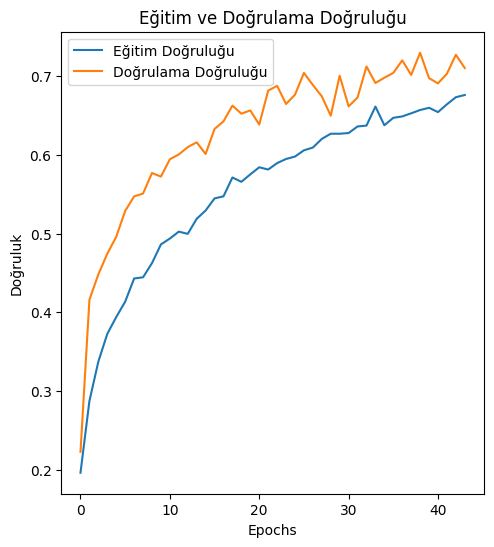

In [16]:
# Eğitim ve doğrulama doğruluğunu ve kaybını görselleştirme
plt.figure(figsize=(12, 6))

# Eğitim doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()


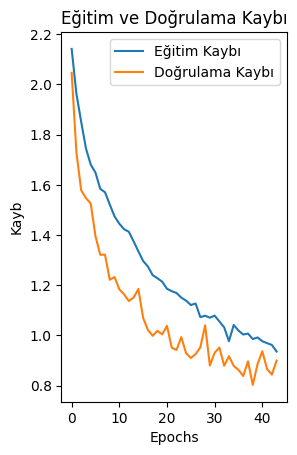

In [17]:
# Eğitim kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayb')
plt.legend()

plt.show()